# 1. Introduction

I built the Convolutional Neural Network (CNN) for digits recognition trained on [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset with keras API (Tensorflow backend). The project is very helpful to understand how CNN works at different layers. The current best score of this network is 0.9967.

<img src="http://img1.imagilive.com/0717/mnist-sample.png" ></img>

In [2]:
# core and utility packages
import pandas as pd
import numpy as np
import itertools

# visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

# modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# keras
# from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras import models

np.random.seed(2)

# 2. Data preparation
## 2.1 Load data

In [3]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


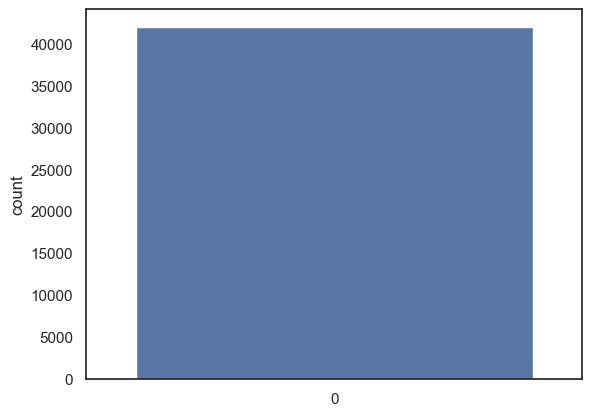

In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

## 2.2 Normalization

CNN converg faster on [0..1] data than on [0..255].

In [5]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 2.3 Reshape

In [6]:
X_train.shape


(42000, 784)

In [7]:
test.shape

(28000, 784)

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1), the first dimension of X_train/test is samples
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
X_train.shape

(42000, 28, 28, 1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. 

## 2.4 Label encoding

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train_value = Y_train # keep the origianl label
Y_train = to_categorical(Y_train, num_classes = 10)
Y_train.shape
#Y_train_value = np.argmax(Y_train, axis=1) # keep the origianl label

(42000, 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.5 Split training and valdiation set 

In [10]:
# Set the random seed
random_seed = 2

In [11]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
X_train.shape

(37800, 28, 28, 1)

The train set is split into two parts : a small fraction (10%) became the validation set and the rest (90%) is used to train the model.

We can get a better sense for one of these examples by visualising the image and looking at the label.

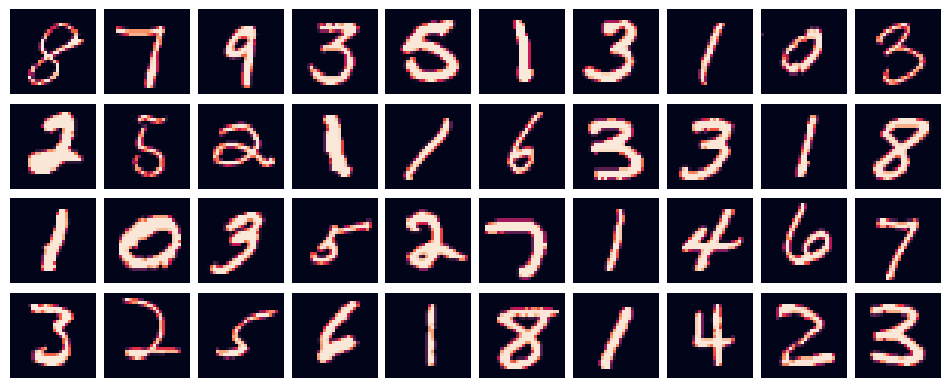

In [12]:
# preview the images first
plt.figure(figsize=(12,4.8))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(X_train[i].reshape((28,28)),interpolation='nearest')
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# 3. CNN
## 3.1 Define the model

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 16 filters for the two firsts conv2D layers and 32 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. 

Combining convolutional and pooling layers, CNN are able to generate various local features.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored for each training sample. This technique can force the network to learn features in a distributed way and reduces the overfitting. 

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network. 

Batch normalization reduces the amount by what the hidden unit values shift around.

Adding another layer of Conv2D->MaxPool2D->Dropout can help the network to capture more complicated features.

The Flatten layer is used to convert the final feature maps into a one single 1D vector.  It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. Now all the featrues are combined together to make final judgement. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class [0,9].

In [13]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> [Dense -> Dropout]*2 -> Softmax

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 16)        0         
 D)                                                              
                                                        

## 3.2 Complie the model with loss function and optimizer

The loss function measures the error rate between the oberved labels and the predicted labels. The "categorical_crossentropy" loss function is suitable for categorical classifications (>2 classes) .

Adam a very effective optimizer to speed up the training of parameters.

The metric function "accuracy" is used is to evaluate the performance the model.

In [14]:
# Define the optimizer
optimizer = Adam(lr=1e-4)

In [15]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

## 3.3 Data augmentation 

In order to increase the training data, the original digits are  transformed to reproduce the variations occuring when someone is writing a digit:

   - Randomly rotate some training images by 10 degrees
   - Randomly  Zoom by 10% some training images
   - Randomly shift images horizontally by 10% of the width
   - Randomly shift images vertically by 10% of the height

The improvement is important : 
   - Without data augmentation I obtained an accuracy of 98.114%
   - With data augmentation I achieved 99.67% of accuracy

In [16]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [17]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

datagen.fit(X_train)

## 3.4 Fit the model

With an annealer, we can set a relative large rating rate in the beginning to approch the global minimum fast, then reduce the learning rate by 10% every epoch to find the best parameters smoothly. 

In [18]:
# Set a learning rate annealer
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

# Turn epochs to 30 to get 0.9967 accuracy
epochs = 30 
batch_size = 86

In [19]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[annealer])

Epoch 1/30


C:\Users\FEMI\AppData\Local\Temp\ipykernel_14800\3912400441.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),


439/439 - 45s - loss: 0.4832 - accuracy: 0.8479 - val_loss: 0.2086 - val_accuracy: 0.9386 - lr: 0.0010 - 45s/epoch - 102ms/step
Epoch 2/30
439/439 - 47s - loss: 0.1489 - accuracy: 0.9545 - val_loss: 0.0488 - val_accuracy: 0.9852 - lr: 9.0000e-04 - 47s/epoch - 107ms/step
Epoch 3/30
439/439 - 65s - loss: 0.1105 - accuracy: 0.9665 - val_loss: 0.0358 - val_accuracy: 0.9914 - lr: 8.1000e-04 - 65s/epoch - 147ms/step
Epoch 4/30
439/439 - 42s - loss: 0.0959 - accuracy: 0.9729 - val_loss: 0.0321 - val_accuracy: 0.9912 - lr: 7.2900e-04 - 42s/epoch - 95ms/step
Epoch 5/30
439/439 - 47s - loss: 0.0803 - accuracy: 0.9756 - val_loss: 0.0307 - val_accuracy: 0.9907 - lr: 6.5610e-04 - 47s/epoch - 106ms/step
Epoch 6/30
439/439 - 56s - loss: 0.0726 - accuracy: 0.9784 - val_loss: 0.0287 - val_accuracy: 0.9917 - lr: 5.9049e-04 - 56s/epoch - 128ms/step
Epoch 7/30
439/439 - 43s - loss: 0.0660 - accuracy: 0.9804 - val_loss: 0.0241 - val_accuracy: 0.9924 - lr: 5.3144e-04 - 43s/epoch - 97ms/step
Epoch 8/30
439/4

# 4. Evaluate the model
## 4.1 Training and validation curves

KeyError: 'val_acc'

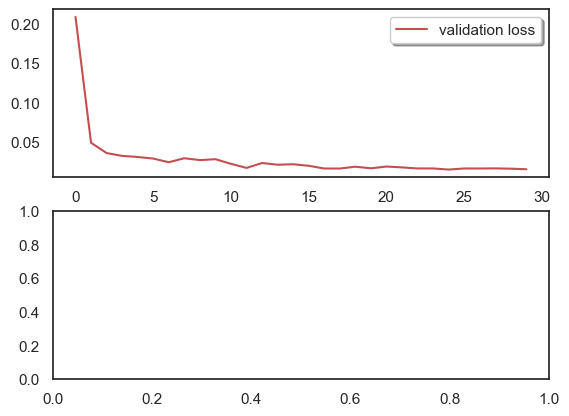

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
#ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

#ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

132/132 [==============================] - 3s 15ms/step


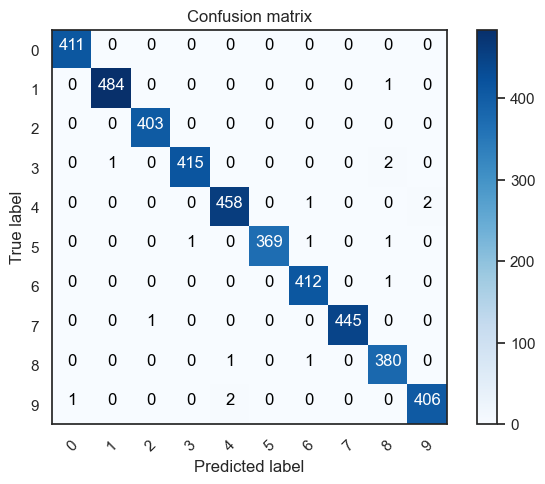

In [21]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

Let's investigate for errors. 

I want to see the most important errors . For that purpose i need to get the difference between the probabilities of real value and the predicted ones in the results.

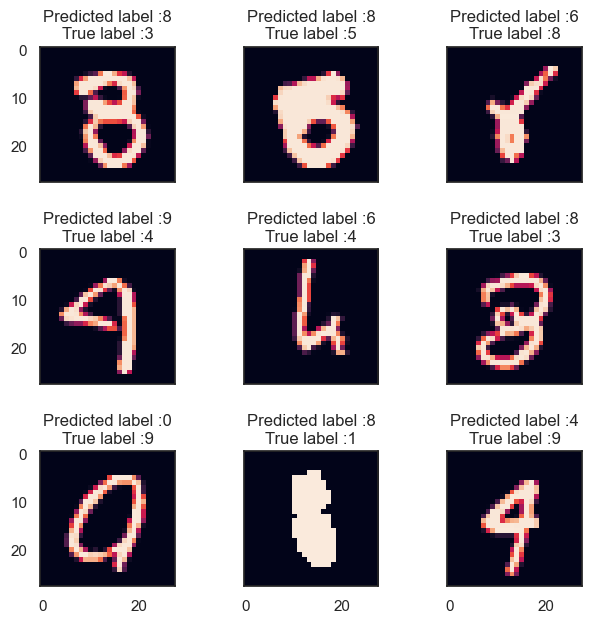

In [22]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(7,7))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 9 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

The most important errors are also the most intrigous. 

For those six case, the model is not ridiculous. Some of these errors can also be made by humans, especially for one the 9 that is very close to a 4. The last 9 is also very misleading, it seems for me that is a 0.

## 4.3 Generate Results

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 15s 16ms/step


In [24]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

# 5. Visualize the model

## 5.1 Visualize the metrix of first convolutional layer

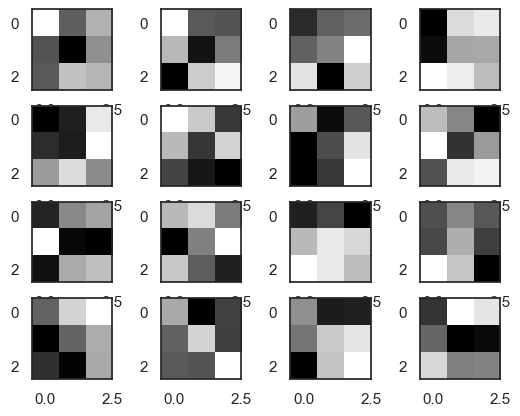

In [25]:
layer1 = model.layers[0]
layer1.name
conv2d_1w = layer1.get_weights()[0][:,:,0,:]
for i in range(1,17):
      plt.subplot(4,4,i)
      plt.imshow(conv2d_1w[:,:,i-1],interpolation="nearest",cmap="gray")
plt.show()

## 5.2 Visualize the output of convolutional and pooling layers

1/1 [==============================] - 0s 270ms/step


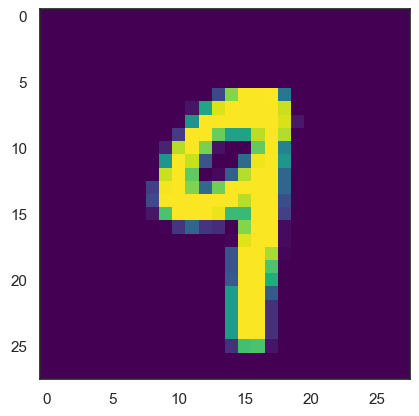

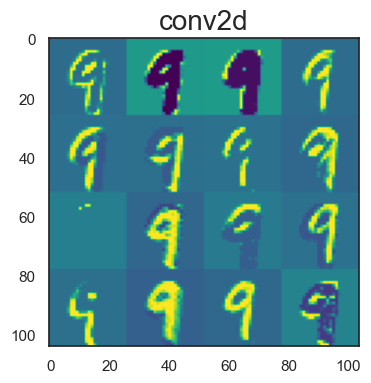

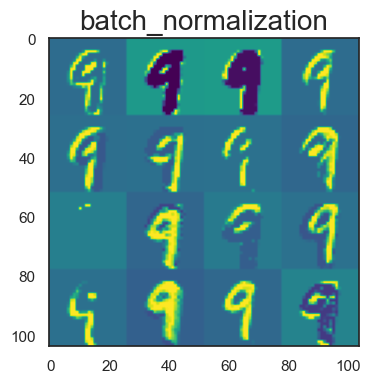

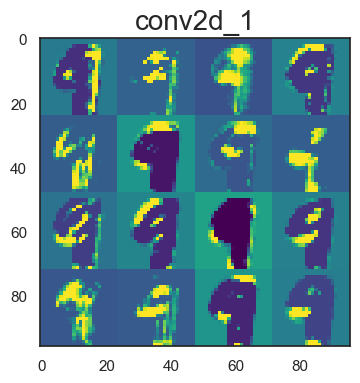

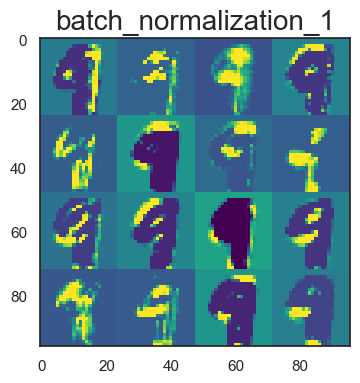

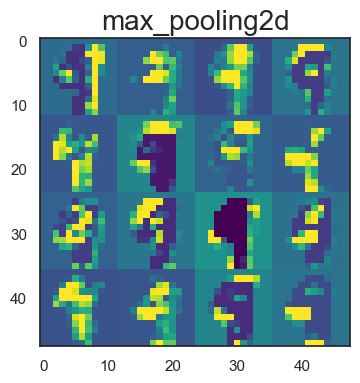

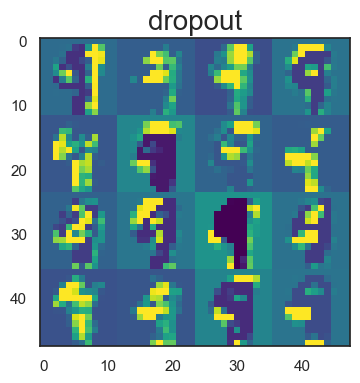

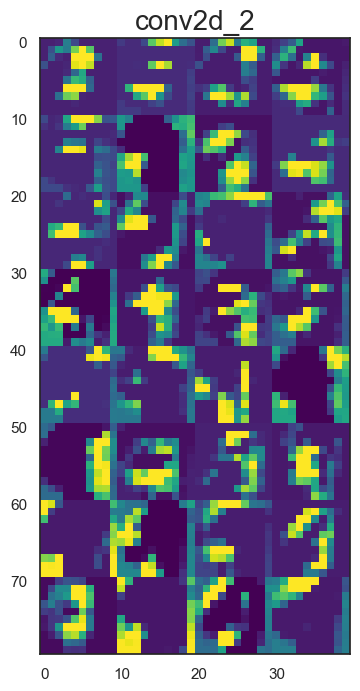

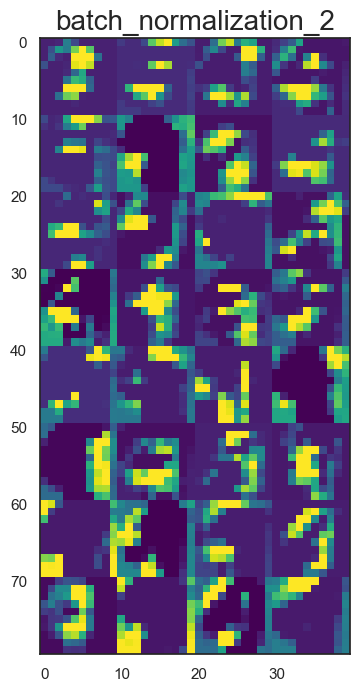

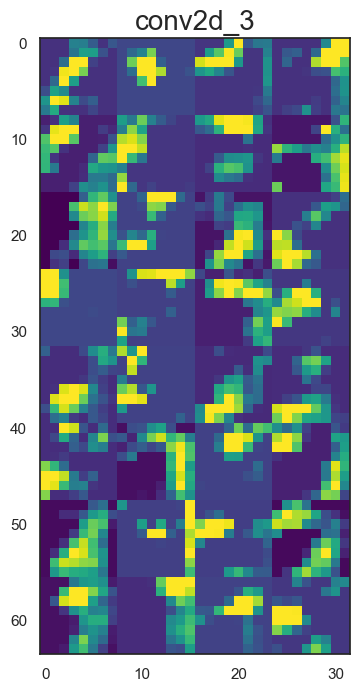

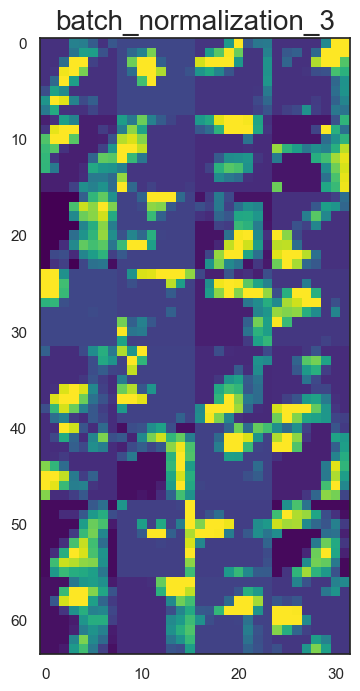

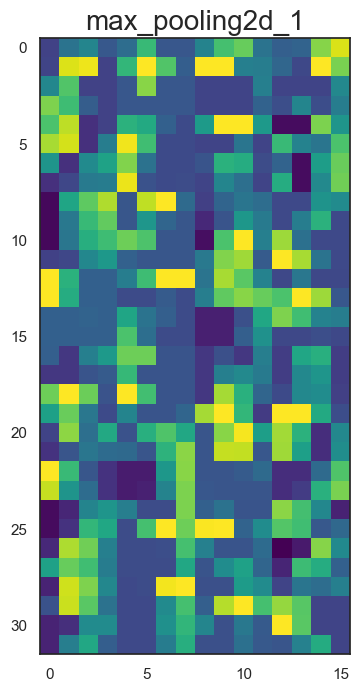

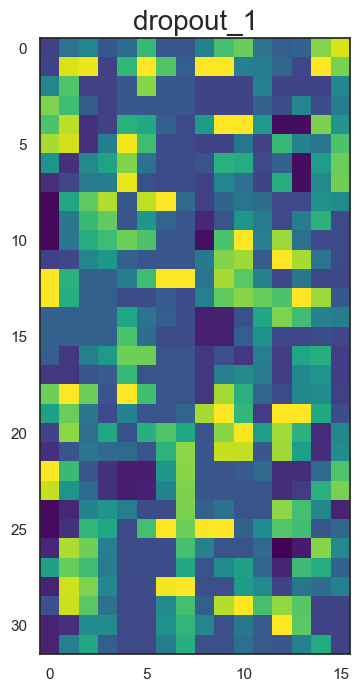

In [28]:
# visualize convolution and pool layer
test_im = X_train[2]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')

# activation output
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) 
images_per_row = 4
for layer_name, layer_activation in zip(layer_names[:12], activations):
    #if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name, fontsize = 20)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## 5.3 Visualize the output of fully connected layer

1/1 [==============================] - 0s 24ms/step


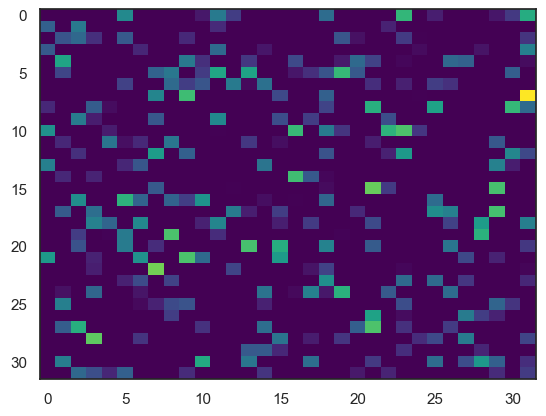

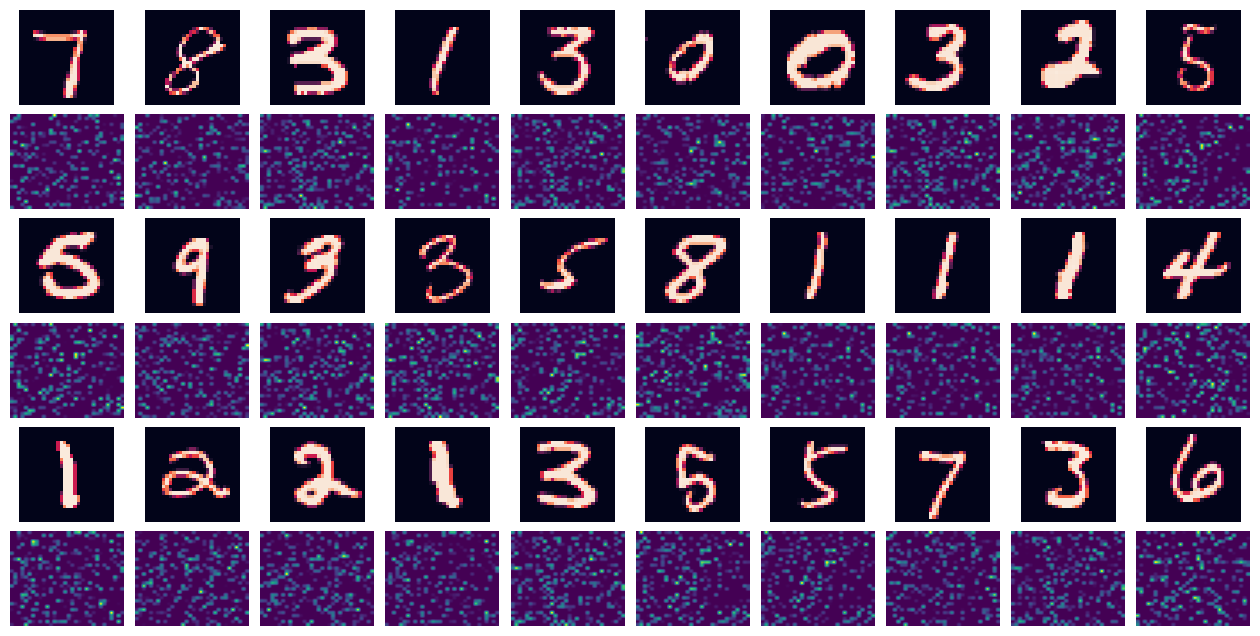

In [30]:
#visualize full conected layer
fc_layer = model.layers[-3]
activation_model = models.Model(inputs=model.input, outputs=fc_layer.output)
activations = activation_model.predict(test_im.reshape(1,28,28,1))   
activation = activations[0].reshape(32,32)
plt.imshow(activation, aspect='auto', cmap='viridis')

# organize the training images by label
Y_train_value_df = pd.DataFrame(Y_train_value,columns=['label'])
Y_train_value_df['pos']=Y_train_value_df.index
Y_train_label_pos = Y_train_value_df.groupby('label')['pos'].apply(list)
pos = Y_train_label_pos[1][0]

#display 3 rows of digit image [0,9], with last full connected layer at bottom
plt.figure(figsize=(16,8))
x, y = 10, 3
for i in range(y):  
    for j in range(x):
        # digit image
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = Y_train_label_pos[j][i] # j is label, i in the index of the list
        plt.imshow(X_train[pos].reshape((28,28)),interpolation='nearest')
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        activations = activation_model.predict(X_train[pos].reshape(1,28,28,1))   
        activation = activations[0].reshape(32,32)
        plt.imshow(activation, aspect='auto', cmap='viridis')
        plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()